# DYNAMITE and Bayes-LOSVD

BayesLOSVD is a tool for extraction of histogrammed LOSVDs from galaxy-spectra. This notebook shows how to use BayesLOSVD output with DYNAMITE.

## Data Preparation 

There are three steps in the data-preparation:

1. convert Bayes-LOSVD output to ECSV file
2. add the PSF to the ECSV file header
3. create auxillary files aperture.dat and bins.dat


I'll demonstrate these steps using Michela's CR galaxy IC0719.

**Note for public release** - swap to the followwing: I'll demonstrate these steps using the example `NGC0000-SP_results.hdf5`. This file comes from running the example dataset provided with Bayes-LOSVD, and it contains LOSVDs for every spatial bin of a galaxy. See the [BayesLOSVD documentation](https://github.com/jfalconbarroso/BAYES-LOSVD) for instructions on how to create such files. For convenience, a copy of `NGC0000-SP_results.hdf5` is provided in this directory.

#### Convert Bayes-LOSVD output to ECSV file

First let's make an "empty" BayesLOSVD object,

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dynamite as dyn

In [2]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(weight=1.,
                                       hist_width=1,
                                       hist_center=0,
                                       hist_bins=0,
                                       type='BayesLOSVD')

We've had to provide some default values for certain keyword parameters, but they won't be used. All we want it to able to use the method `write_losvds_to_ecsv_format` to convert the results to the required ECSV format,

In [3]:
filename = 'IC0719_input/IC0719_CaT_1-SP_results.hdf5'
BayesLOSVD.write_losvds_to_ecsv_format(filename,
                                       outfile='IC0719_input/bayes_losvd_kins.ecsv')

This creates a file `bayes_losvd_kins.ecsv`.

#### add the PSF to the ECSV file header

Next add the PSF into the header of this file. This is specified as a Gaussian mixture with a list of sigmas and weights. Change these numbers to the correct PSF for your data,

In [4]:
BayesLOSVD.add_psf_to_datafile(sigma=[1.,2.],
                               weight=[0.6,0.4],
                               datafile='IC0719_input/bayes_losvd_kins.ecsv')

#### create auxillary files

We now create some auxillary files (`aperture.dat` and `bins.dat` files) which are used to bin orbit libraries. We first need to re-create the `BayesLOSVD` object, readin-in the ECSV table,

In [5]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       weight=1.,
                                       type='BayesLOSVD')

To create the auxillary files, we need to provide an angle (90 - position angle), and the galaxy center in pixel units. The center can either be a tuple $(x_0,y_0)$ or - as is done here - the string `'max_flux'` to use the pixel with maximum flux as center,

In [65]:
BayesLOSVD.write_aperture_and_bin_files(filename=filename,
                                        angle_deg=90.-53.,
                                        center='max_flux',
                                        aperture_filename='IC0719_input/aperture.dat',
                                        bin_filename='IC0719_input/bins.dat')

[INFO] 11:07:53 - kinematics.BayesLOSVD - Loading IC0719_input/IC0719_CaT_1-SP_results.hdf5 data
[INFO] 11:07:55 - kinematics.BayesLOSVD - load_hdf5 is DONE


The two files are created in the directory `IC0719_input`.

All of these data preparation steps should be carried out before the main DYNAMITE run.

## Looking at the BayesLOSVD output

We can read create a new BayesLOSVD object, reading in all files we have just created,

In [66]:
BayesLOSVD = dyn.kinematics.BayesLOSVD(datafile='IC0719_input/bayes_losvd_kins.ecsv',
                                       aperturefile='IC0719_input/aperture.dat',
                                       binfile='IC0719_input/bins.dat',
                                       weight=1.,
                                       type='BayesLOSVD')

The data is stored in the data attribute,

In [67]:
BayesLOSVD.data

binID_BayesLOSVD,binID_dynamite,losvd [35],dlosvd [35],v,sigma
int64,int64,float64,float64,float64,float64
0,1,0.015259378139774543 .. 0.0019416323497681881,0.01989741285762346 .. 0.005968342942902846,25.139417714854343,150.30443226059708
1,2,0.004106415902383198 .. 0.004508561382520821,0.011563090410035497 .. 0.012054460545721686,20.64428749441824,135.913029588071
2,3,0.007710072525254317 .. 0.015386889344653404,0.01510201752165599 .. 0.016906022327590003,12.405493855238928,155.33695847562882
3,4,0.004090768456268483 .. 0.0007614242053367949,0.01024960639403547 .. 0.002376875278290962,28.126960053791034,122.30574005867527
4,5,0.0018553695864067883 .. 0.002205535931192645,0.005951478462937457 .. 0.006721059434023896,13.213971588565506,114.6056209979196
5,6,0.0189432749850374 .. 0.005585052051007471,0.09528282444614967 .. 0.08714230636193271,39.94863636717035,171.18152737870957
6,7,0.019946842755926494 .. 0.002535855487729973,0.018711449668939888 .. 0.0078523083547063,42.91353616565235,158.24235963279546
7,8,0.0043715624686085875 .. 0.0019774594743697392,0.012516282251890123 .. 0.00635984346952707,26.973097959151097,125.46661842022787
8,9,0.013105487122553274 .. 0.001582232344009336,0.016294123929419715 .. 0.005274471848778314,29.120703908039957,141.27489949798658


**Note on bin IDs**: there are two binIDs in this table: BayesLOSVD and DYNMAITE. The differeces between these are:

1. BayesLOSVD bins are zero-indexed, while DYNAMITE (specifically fortran code) requires that  bins are 1-indexed,
2. BayesLOSVD bins may have some gaps (as some bins may be masked) while DYNATIMTE assumes the binIDs increase without gaps

You won't need to worry about this difference when running DYNAMITE, but be aware that of the difference for any later analysis.

The remaining columns are the LOSVD itself (`losvd`), the error on the LOSVD (`dlosvd`), its mean `v` and standard deviation `sigma`. BayesLOSVD represents the LOSVD as a sequence of weights $L_i$ in velocity bins $v_i$. Details of the velocity array are stored as metadata to the data table,

In [68]:
print('Bayes-LOSVD table contains meta-data about: ', BayesLOSVD.data.meta.keys())
print('     velocity spacing of bins = ', BayesLOSVD.data.meta['dv'])
print('     number of spatial bins = ', BayesLOSVD.data.meta['nbins'])
print('     number of velocty bins = ', BayesLOSVD.data.meta['nvbins'])
print('     etc...')

Bayes-LOSVD table contains meta-data about:  odict_keys(['dv', 'nbins', 'nvbins', 'vcent', 'PSF'])
     velocity spacing of bins =  40.0
     number of spatial bins =  235
     number of velocty bins =  35
     etc...


BayesLOSVD calculates the multi-dimensional posterior on the LOSVD weights $L_i$. The columns in the table above give the median and 68% Bayesian credible intervals for the weight in each velocity bin.

One point to consider is normalisation. The posterior samples created by BayesLOSVD are normnalised to sum to 1 i.e. 

$$
\sum_i L_i = 1
$$

this is acheieved by using the `simplex` datatype in STAN). The results file, however, gives median values per velocity bin, and these are not normalised as expected. Let's call these median value,

$$
l_i = \mathrm{median}(L_{i})
$$

and look at a histogram of the sums of the $l_i$ in each spatial bin,

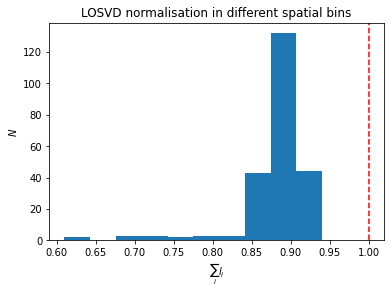

In [69]:
plt.hist(np.sum(BayesLOSVD.data['losvd'], 1))
plt.axvline(1., ls='--', color='r')
plt.gca().set_xlabel('$\sum_i l_{i}$')
plt.gca().set_ylabel('$N$')
_ = plt.gca().set_title('LOSVD normalisation in different spatial bins')

This peaks around 0.9 and, in some cases, is as low as 0.6! It will be important to acccount for this. When calculating moments of the LOSVDs, for example, we will have to re-normalise. Let's define the re-normalised `losvd` as

$$
\hat{l}_{i} = \frac{l_{i}}{\sum_i l_{i}}
$$

This quantity $\hat{l}_{i}$ is what we will use to make point estimates of the the mean and standard deviation LOSVD which appear in the `v` and `sigma` columns of the data-table,

$$
v = \sum_i v_i * \hat{l}_{i}
$$

$$
\sigma = \left[ \sum_i (v_i-v)^2 * \hat{l}_{i} \right]^{\frac{1}{2}}
$$

Let's plot a few examples of LOSVDs and their Gaussian approximations using `v` and `sigma` in different spatial bins,

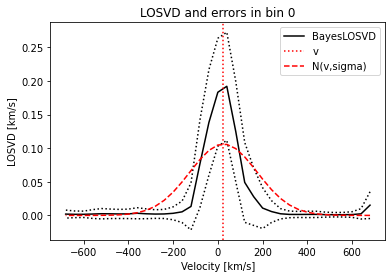

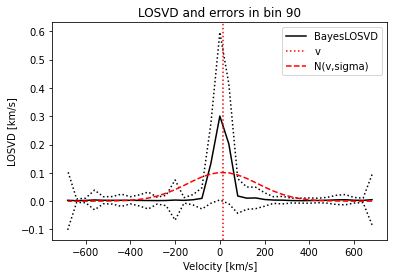

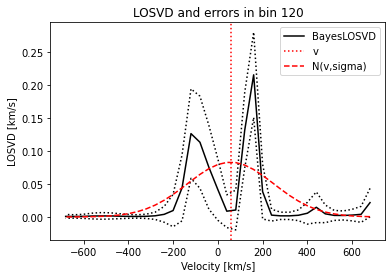

In [12]:
from scipy import stats

for bin_idx in [0, 90, 120]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD and errors in bin {bin_idx}')
    plt.gca().legend()
    plt.show()

In the final example, the LOSVD is bimodal, and this is clearly not well matched at all by the Gaussian. But even in the previous two, unimodal, examples, the Gaussian approximations is not good. The Gaussians are much wider that the BayesLOSVD histograms. Why is this? Let's look at the two unimodal LOSVDs again, this time on a log-scale,

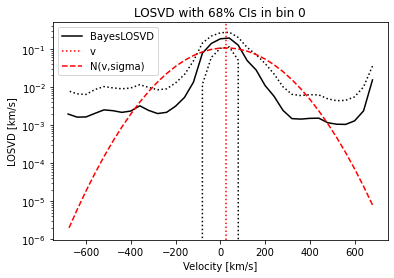

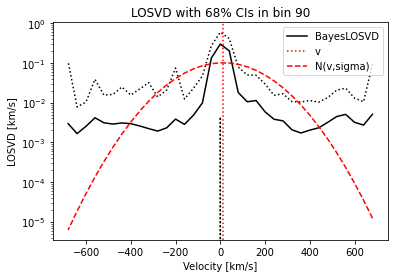

In [13]:
for bin_idx in [0, 90]:
    mu = BayesLOSVD.data['losvd'][bin_idx,:]
    sig = BayesLOSVD.data['dlosvd'][bin_idx,:]
    vcent = BayesLOSVD.data.meta['vcent']
    plt.plot(vcent, mu, '-k', label='BayesLOSVD')
    plt.plot(vcent, mu+sig, ':k')
    plt.plot(vcent, mu-sig, ':k')
    v, sig = BayesLOSVD.data['v'][bin_idx], BayesLOSVD.data['sigma'][bin_idx]
    plt.gca().axvline(v, color='r', ls=':', label='v')
    nrm = stats.norm(v, sig)
    pdf = nrm.pdf(vcent)
    plt.gca().plot(vcent, pdf/np.sum(pdf), color='r', ls='--', label='N(v,sigma)')
    plt.gca().set_xlabel('Velocity [km/s]')
    plt.gca().set_ylabel('LOSVD [km/s]')
    _ = plt.gca().set_title(f'LOSVD with 68% CIs in bin {bin_idx}')
    plt.gca().legend()
    plt.gca().set_yscale('log')
    plt.show()

we see that BayesLOSVD does not force the LOSVD to decay at large velocities. The fat tails give rise to large standard deviations. The `sigma` are unrepresentative of the width of the main body of the distribution. So, sigma maps for BayesLOSVD output would likely be useless. Quantile maps may be better.

## Running DYNAMITE

To run DYNAMITE with BayesLOSVD output, you need to specify `type: BayesLOSVD` in the kinemtics section of the configuration file. An example `IC0719_dynmaite_config.yaml` is provided in this directory. The relevant part for us is the following,

    system_components:
        ...
        stars:
            ...
            kinematics:
                MUSE_CaT:
                    weight: 1.0
                    type: BayesLOSVD
                    datafile: "bayes_losvd_kins.ecsv"
                    aperturefile: "aperture.dat"
                    binfile: "bins.dat"

The entry `MUSE_caT` is a descriptive name, which can be any name we wish to use for this kinematic dataset. In this case, the kinematics came from the calcium triplet using MUSE data, hence `MUSE_caT`. The `type` must be `BayesLOSVD`, and the filenames should be those produced in the data-preparaition step.

To read the configuration file,

In [70]:
fname = 'IC0719_dynamite_config.yaml'
c = dyn.config_reader.Configuration(fname, reset_logging=True)
c.remove_all_existing_output(wipe_all=True)

[INFO] 11:19:33 - dynamite.config_reader.Configuration - Resetting logging configuration
[INFO] 11:19:33 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 11:19:33 - dynamite.config_reader.Configuration - Config file IC0719_dynamite_config.yaml read.
[INFO] 11:19:33 - dynamite.config_reader.Configuration - io_settings...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - io_settings...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - system_attributes...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - model_components...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - model_components...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - system_parameters...
[INFO] 11:19:33 - dynamite.config_reader.Configuration - orblib_settings...
[INFO] 11:19:33 - d

When the configuration file is read into the configration object `c`. A `BayesLOSVD` object has been created, and we can extract this: it belongs to the `stars` component, and is the first (and in this case only) data set in the list of kinematic_data,

In [71]:
stars = c.system.get_component_from_name('stars')
BayesLOSVD = stars.kinematic_data[0]
print(type(BayesLOSVD))

<class 'kinematics.BayesLOSVD'>


Some quantites have been automatically set when the ocnfiguration has been read in. For example, the following settings define the histogram bins for storing LOSVDs of the orbit libraries,

In [72]:
print('Orbit LOSVD histogram width = ', BayesLOSVD.hist_width)
print('Orbit LOSVD histogram n bins = ', BayesLOSVD.hist_bins)
print('Orbit LOSVD histogram velocity spacing = ', BayesLOSVD.hist_width/BayesLOSVD.hist_bins)

Orbit LOSVD histogram width =  2640.0
Orbit LOSVD histogram n bins =  661
Orbit LOSVD histogram velocity spacing =  3.993948562783661


These defaultss will scale with the input data provided - the range is double the data range, and the velocity spacing is about a tenth of the data spacing. To override the defaults, you can alternatively set the quantities in the configuration file, e.g.

    kinematics:
        MUSE_CaT
            hist_width: ...
            hist_bins: ...
            ...
                  
Let's run an orbit library...?

In [73]:
parset0 = c.all_models.parspace.get_parset()

mod0 = dyn.model.Model(system=c.system, settings=c.settings, parspace=c.parspace, parset=parset0)
mod0.setup_directories()

In [74]:
orblib0 = mod0.get_orblib()

[INFO] 11:20:44 - orblib.LegacyOrbitLibrary - Calculating initial conditions
[INFO] 11:20:44 - orblib.LegacyOrbitLibrary - Calculating initial conditions
[INFO] 11:21:54 - orblib.LegacyOrbitLibrary - Integrating orbit library tube orbits
[INFO] 11:21:54 - orblib.LegacyOrbitLibrary - Integrating orbit library tube orbits
[INFO] 11:22:18 - orblib.LegacyOrbitLibrary - Integrating orbit library box orbits
[INFO] 11:22:18 - orblib.LegacyOrbitLibrary - Integrating orbit library box orbits


/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


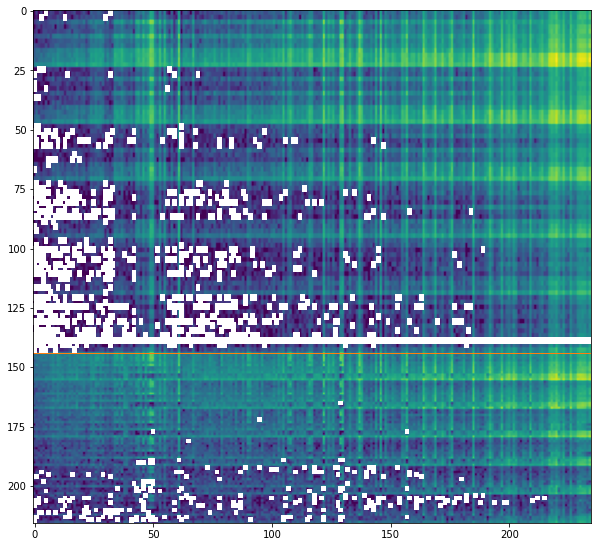

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(np.log10(np.sum(orblib0.losvd_histograms[0].y, (1))))
ax.axhline(6*4*3*2, ls='-', color='C1', lw=1)

In [20]:
from plotbin import display_bins

display_bins.display_bins

<function plotbin.display_bins.display_bins(x, y, bin_num, vel_bin, **kwargs)>

In [21]:
aperture_fname = c.settings.io_settings['input_directory']+BayesLOSVD.aperturefile

lines = [line.rstrip('\n').split() for line in open(aperture_fname)]
strhead = lines[0]
minx = float(lines[1][0])
miny = float(lines[1][1])
sx = float(lines[2][0])
sy = float(lines[2][1])
maxx = sx + minx
sy = sy + miny
angle_deg = float(lines[3][0])  # - 90.0 + 180
nx = int(lines[4][0])
ny = int(lines[4][1])
dx = sx / nx

xr = np.arange(nx, dtype=float) * dx + minx + 0.5 * dx
yc = np.arange(ny, dtype=float) * dx + miny + 0.5 * dx

xi = np.outer(xr, (yc * 0 + 1))
xt = xi.T.flatten()
yi = np.outer((xr * 0 + 1), yc)
yt = yi.T.flatten()

radeg = 57.2958
xi = xt
yi = yt

bin_fname = c.settings.io_settings['input_directory']+BayesLOSVD.binfile
lines_bins = [line.rstrip('\n').split() for line in open(bin_fname)]
i = 0
str_head = []
i_var = []
grid = []
while i < len(lines_bins):
    for x in lines_bins[i]:
        if i == 0:
            str_head.append(str(x))
        if i == 1:
            i_var.append(int(x))
        if i > 1:
            grid.append(int(x))
    i += 1
str_head = str(str_head[0])
i_var = int(i_var[0])
grid = np.ravel(np.array(grid))

# bins start counting at 1 in fortran and at 0 in idl:
grid = grid - 1

# Only select the pixels that have a bin associated with them.
s = np.ravel(np.where((grid >= 0)))

x, y = xi[s], yi[s]

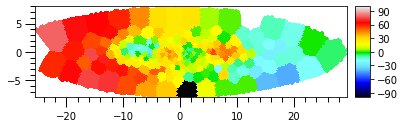

In [22]:
display_pixels.display_pixels(x, y, BayesLOSVD.data['v'][grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-100,
                              vmax=100,
                              colorbar=True)

Some orbits look fine:

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


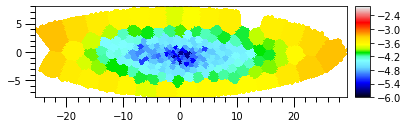

In [23]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[0])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:1061: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin
/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/matplotlib-3.3.4-py3.7-macosx-10.9-x86_64.egg/matplotlib/colors.py:576: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


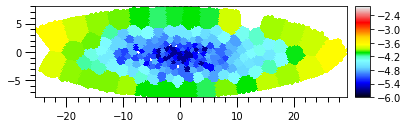

In [24]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[56])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


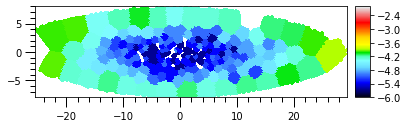

In [25]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[87])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

But some are so... weird!? e.g.

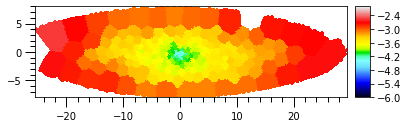

In [26]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[47])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

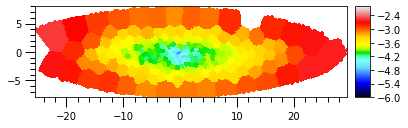

In [27]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[44])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

Looks like a banana orbit, perhaps... but aren't these meant to be point symmetrized?

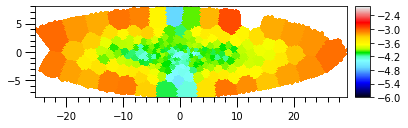

In [28]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[151])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

And then many don't exist... at all!

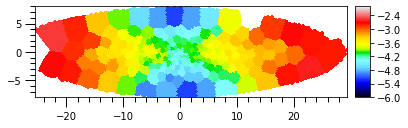

In [29]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[153])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

Is this a problems with the mge not being correct? Or with the PA? Or the potential parameters...? I have no idea.

Let's look at some box orbits:

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


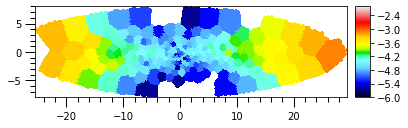

In [30]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[189])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


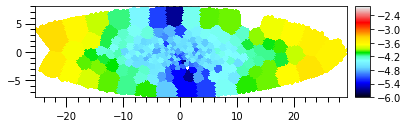

In [31]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[215])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-2,
                              colorbar=True)

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


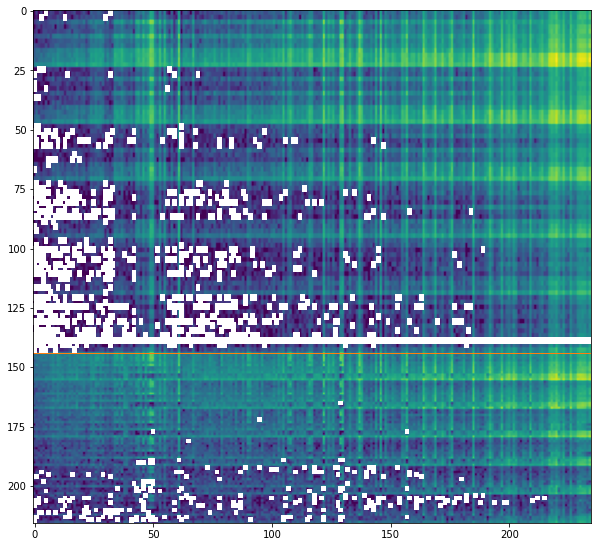

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(np.log10(np.sum(orblib0.losvd_histograms[0].y, (1))))
ax.axhline(6*4*3*2, ls='-', color='C1', lw=1)

In [40]:
np.sum(np.sum(orblib0.losvd_histograms[0].y, (1,))==0., 1).shape

(216,)

(0.0, 1.0)

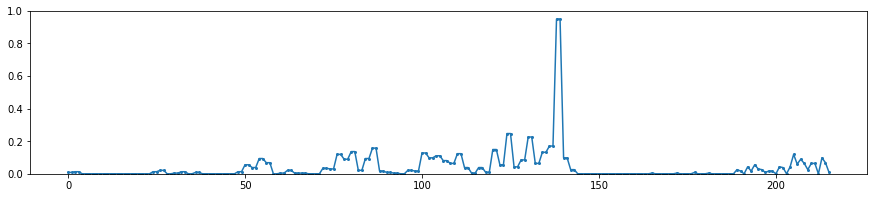

In [50]:
n_bins_empty = np.sum(np.sum(orblib0.losvd_histograms[0].y, (1,))==0., 1)
n_bins_tot = orblib0.losvd_histograms[0].y.shape[2]
frac_bins_empty = n_bins_empty/n_bins_tot
fig, ax = plt.subplots(1, 1, figsize=(15,3))
ax.plot(frac_bins_empty, '-o', ms=2)
ax.set_ylim(0, 1)

In [52]:
np.max(n_bins_empty), np.argmax(n_bins_empty)

(223, 138)

/Users/pjethwa/miniconda3/envs/dyn_env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


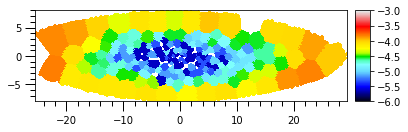

In [63]:
img = np.log10(np.sum(orblib0.losvd_histograms[0].y, (1,))[136])
display_pixels.display_pixels(x, y,
                              img[grid[s]],
                              pixelsize=dx,
                              angle=angle_deg,
                              cmap='sauron',
                              vmin=-6, vmax=-3,
                              colorbar=True)